Statistical errors of CNN models

#read current
#load model and calculate out put od model
#plot 3d error of Bfield

In [20]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn.functional as F
if torch.cuda.device_count():
    device = 'cuda'
    map_location = 'cuda:0'
    print('Good to go')
else:
    device = 'cpu'
    map_location = torch.device('cpu')
    print('Using cpu')
    
from Neural_network import Generative_net, ResidualEMNSBlock_3d, BigBlock, weight_init, eMNS_Dataset

Good to go


In [21]:
#load saved  model
from Neural_network import Generative_net,Generative_net_test, ResidualEMNSBlock_3d, BigBlock, weight_init, eMNS_Dataset

num_input = 8
output_shape = (3,16,16,16)
SB_args = (64,64,4,1) # (Cin, Cout, num_repeat, num_block)
BB_args = (2,3) # (scale_factor, num_block)
SB_block = ResidualEMNSBlock_3d 
BB_block = BigBlock
DF = False # whether using divergence free model

Generative_network = Generative_net_test(SB_args, BB_args, SB_block, BB_block, num_input=num_input, output_shape= output_shape)
Generative_network = torch.load('EMS_CNN_ETH.pt', map_location=map_location)
Generative_network.eval()
Generative_network.to(device)

Generative_net_test(
  (proj): Linear(in_features=8, out_features=4096, bias=True)
  (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (conv3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (conv4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (conv5): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (conv6): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (conv7): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (conv8): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (conv9): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (conv10): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (conv11): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (conv12): Conv3d(64, 6

In [22]:
from ReadData import ReadETHFolder, ReadETHFile
foldername="./ETH_Data/v/"
currentname = "./ETH_Data/"+"currents_3787.h5"
file_num = 1300
data_shape = (16,16,16,3)
Bfield = torch.tensor(ReadETHFolder(foldername,file_num, data_shape)).permute(0,4,1,2,3)
current = torch.tensor(ReadETHFile(currentname))
current = current[0:Bfield.shape[0],:]

In [ ]:
# position = data[:,0:3,2:18,2:18,2:18]
# Bfield = data[:,3:,2:18,2:18,2:18]
#data normalization
min_current=torch.load("./normalize_data/cnn_min_current_ETH.pt")
max_current=torch.load("./normalize_data/cnn_max_current_ETH.pt")
min_Bfield=torch.load("./normalize_data/cnn_min_Bfield_ETH.pt")
max_Bfield=torch.load("./normalize_data/cnn_max_Bfield_ETH.pt")

dimB = Bfield.shape
dimc = current.shape
print(min_current.shape)
print(min_Bfield.shape)

minB=min_Bfield.expand(3,int(Bfield.numel()/3)).reshape(3,dimB[0],dimB[2],dimB[3],dimB[4]).transpose(0,1)
maxB=max_Bfield.expand(3,int(Bfield.numel()/3)).reshape(3,dimB[0],dimB[2],dimB[3],dimB[4]).transpose(0,1)

ave_current=0.5*(max_current.expand(dimc[0],dimc[1])+min_current.expand(dimc[0],dimc[1]))
diff_current=0.5*(max_current.expand(dimc[0],dimc[1])-min_current.expand(dimc[0],dimc[1]))

current_norm = (current-ave_current)/diff_current
Bfield_norm = (Bfield-(minB+maxB)*0.5)/(0.5*(maxB-minB))

print(current_norm.shape)
print(Bfield_norm.shape)


In [23]:
num_samples, num_current_input = current.shape
_, dimension, grid_x, grid_y, grid_z = Bfield.shape
grid_space = grid_x*grid_y*grid_z
print(grid_x)
print("current shape:",current.shape,"current device:",current.device)
print("Bfied;:",Bfield.shape,"current device:",Bfield.device)

16
current shape: torch.Size([1300, 8]) current device: cpu
Bfied;: torch.Size([1300, 3, 16, 16, 16]) current device: cpu


In [25]:
#calculate estimated normalized Bfield value of CNN 
train_file_num=1000
B_est_norm=torch.zeros(num_samples,dimension,grid_x,grid_y,grid_z)
for i in range (0,num_samples):
    input=current_norm[i,:].to(device).reshape(1,8)
    b = input.float()
    B_est_norm[i]=Generative_network(b)

B_est=B_est_norm*(0.5*(maxB-minB))+0.5*(maxB+minB)
#calculate rmse 
mse_test = F.mse_loss(B_est[train_file_num:,:],Bfield[train_file_num:,:],reduction='sum')
rmse_test = torch.sqrt(mse_test/(1300-train_file_num)/grid_space/3)

mse_train = F.mse_loss(B_est[0:train_file_num,:],Bfield[0:train_file_num,:],reduction='sum')
rmse_train = torch.sqrt(mse_train/train_file_num/grid_space/3)


B_est=B_est.cpu().detach().numpy()
B_est_norm=B_est_norm.cpu().detach().numpy()
Bfield_norm=Bfield_norm.detach().numpy()
current_norm=current_norm.detach().numpy()
Bfield=Bfield.cpu().detach().numpy()


In [29]:
print(B_est_norm.shape)
print(f'rmse_train={rmse_train*1000:.2f}mT')
print(f'rmse_test={rmse_test*1000:.2f}mT')
Bdiff_norm=(B_est_norm-Bfield_norm)
print(Bdiff_norm.shape)
Error_CNN = Bdiff_norm/np.absolute(Bfield_norm)*100
print(B_est.shape)
print(Bfield.shape)

(1300, 3, 16, 16, 16)
rmse_train=0.99mT
rmse_test=1.21mT
(1300, 3, 16, 16, 16)
(1300, 3, 16, 16, 16)
(1300, 3, 16, 16, 16)


tensor(0.0014, dtype=torch.float64)
tensor(0.0042, dtype=torch.float64)
torch.Size([1300, 8])


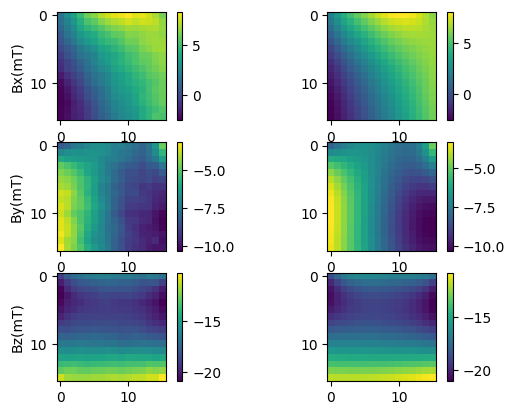

example RMSE: tensor(0.0003, dtype=torch.float64)
my RMSE: 0.0003252070670131307


<Figure size 640x480 with 0 Axes>

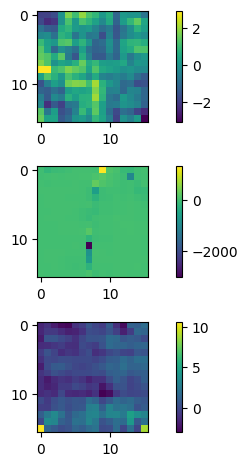

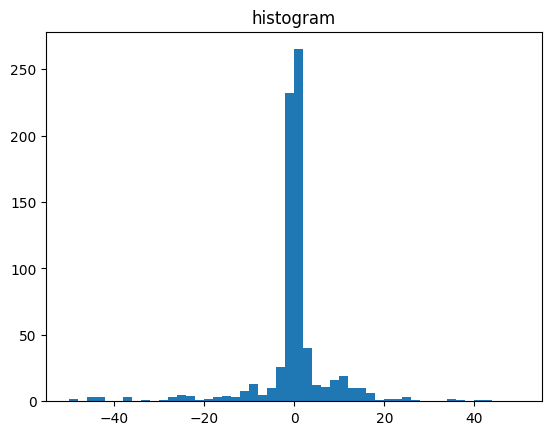

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
loss_norm = F.l1_loss(torch.tensor(B_est_norm),torch.tensor(Bfield_norm))

mse_norm = F.mse_loss(torch.tensor(B_est_norm),torch.tensor(Bfield_norm),reduction='sum')
rmse_norm = torch.sqrt(mse_norm/num_samples/grid_space)

print(loss_norm)
print(rmse_norm)
current_index = 1200
print(current.shape)

z_plane_index= 11
# fig, ax = plt.subplots(3, 2)
# fig.tight_layout(h_pad=2)
fig = plt.figure()
vmin=[0,-12,-2]
vmax=[15 , 5, 22]
MSE_temp = 0
my_error = 0

ylables=['Bx(mT)','By(mT)','Bz(mT)']
# fig.tight_layout(pad=0.4, w_pad=0, h_pad=0)
for i in range(1,4):
    B_est_temp = B_est[current_index,i-1,:,:,z_plane_index]
    # B_est_temp = B_est[current_index,i-1,:,:,:]
    plt.subplot(3,2,2*i-1)
    plt.imshow(B_est_temp*1000)    
    plt.colorbar()
    plt.ylabel(ylables[i-1])
    Bfield_temp = Bfield[current_index,i-1,:,:,z_plane_index]
    # Bfield_temp = Bfield[current_index,i-1,:,:,:]*1000
    plt.subplot(3,2,2*i)
    plt.imshow(Bfield_temp*1000)
    plt.colorbar()
    # print('B_est_temp:',B_est_temp)
    # print('Bfield_temp:',Bfield_temp)
    MSE_temp += F.mse_loss(torch.tensor(B_est_temp),torch.tensor(Bfield_temp),reduction='sum')
    my_error += np.sum((B_est_temp-Bfield_temp)**2)

plt.show()
RMSE_temp = torch.sqrt(MSE_temp/grid_x/grid_y)
RMSE_my = np.sqrt(my_error/grid_x/grid_y)
print('example RMSE:',RMSE_temp)
print('my RMSE:', RMSE_my)
from pylab import *
subplots_adjust(left=0.0,bottom=0.0,top=1,right=1)
fig, ax = plt.subplots(3, 1)
fig.tight_layout()

for i in range(1,4):
    plt.subplot(3,1,i)
    plt.imshow(Error_CNN[current_index,i-1,:,:,z_plane_index])    
    plt.colorbar(fraction=0.04)    

plt.show()

plt.hist(Error_CNN[current_index,:,:,:,z_plane_index].reshape(-1),bins=50,range=[-0.5e2,0.5e2])
plt.title("histogram") 
plt.show()

In [ ]:
a=np.array([[1,2,3],[4,5,6],[7,8,9]])
print(a)
a=a[0:2,:]
print(a)
print(a.shape)


